In [ ]:
# %pip install pyqtgraph
# %pip install PyQt5
# %pip install PySide2 
# %pip install scikit-learn
%pip install seaborn
%pip install vtk
# %pip install apptools
# %pip install envisage
# %pip install pyface
# %pip install traits
%pip install traitsui
%pip install mayavi
%pip install pandas

In [1]:
import PyQt5
import PySide2
import traitsui
import vtk
import mayavi
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from mayavi import mlab
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import make_scorer
from time import time
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.spatial import Delaunay
import seaborn as sns
print('traitsui version:', traitsui.__version__)
print('PySide2 version:', PySide2.__version__)

print("VTK version:", vtk.vtkVersion.GetVTKVersion())
print("Mayavi version:", mayavi.__version__)

traitsui version: 8.0.0
PySide2 version: 5.15.2.1
VTK version: 9.2.6
Mayavi version: 4.8.1


In [41]:
# загрузка датасета вин
df = pd.read_csv('winequality-red.csv',sep=';')
df


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [42]:
# оригинальные колонки датасета
origcols=list(df.columns)
origcols

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

# статистика по значениям качества:

In [43]:
# сколько каких оценок вина встречается
df['quality'].value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

In [44]:
# оценка количества хороших вин(>6.5) и не относящихся к хорошим
df['column_bin'] = pd.cut(df['quality'], bins=[0, 6.5, 8], include_lowest=True,right=True)
bin_counts = df['column_bin'].value_counts()
print(bin_counts)


column_bin
(-0.001, 6.5]    1382
(6.5, 8.0]        217
Name: count, dtype: int64


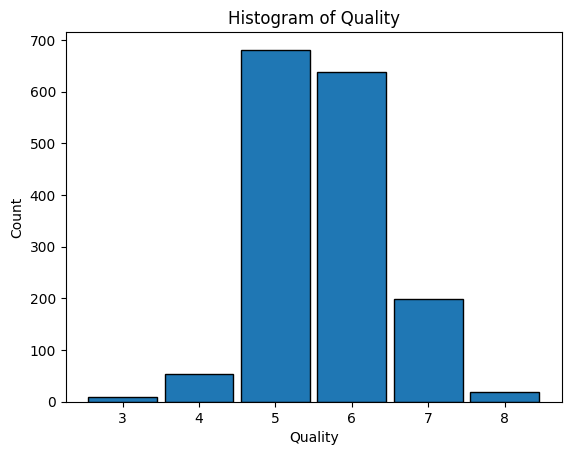

In [45]:
# гистограмма количеств каждой оценки
# Calculate counts of each unique 'quality' value
counts = df['quality'].value_counts().sort_index()

# Calculate bin centers (which are just the unique 'quality' values)
bin_centers = counts.index

# Create new figure
plt.figure()

# Use bar to plot histogram with centered bars
plt.bar(bin_centers, counts, width=0.9, align='center', edgecolor='black', tick_label=bin_centers)

# Add labels and title
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Histogram of Quality')

# Show the plot
plt.show()

In [46]:
# кодирование целевой переменной
# Split the data into features and target variable
X = df[origcols].drop('quality', axis=1)
y = df['quality']

# Convert the target variable into a categorical variable
y = y.apply(lambda x: 'good wine' if x > 6.5 else 'bad wine')

# Encode the target variable 1-хорошие вина, 0 - остальные
le = LabelEncoder()
y_le = le.fit_transform(y)


In [47]:
# повтор-проверка результата (bin_counts) 1382/217
dff = pd.DataFrame(y_le, columns=['ColumnName'])
dff['ColumnName'].value_counts()

ColumnName
0    1382
1     217
Name: count, dtype: int64

In [48]:
# разбиение на тестовую и тренировочную части, подбор гиперпараметров по сетке

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_le, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#применить так же стандартизацию к полному ряду для визуализации
X_t = scaler.transform(X)


In [52]:
# из двух вариантов(с и без указания весов классов, второй вариант svm дал лучшие результаты)

# svm = SVC(class_weight={0: 1382, 1: 217})
# Accuracy: 0.8875
# Confusion Matrix:
# [[273   0]
#  [ 36  11]]

svm = SVC()
# Accuracy: 0.890625
# Confusion Matrix:
# [[271   2]
#  [ 33  14]]
# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
# был выполнен поиск по сетке с полным набором ядер и уже заведомо известно, 
# что rbf показал лучшие результаты, поэтому повторные многократные запуски уже для скорости выполнялиь с фиксированным рбф
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100],
    'kernel': [ 'rbf']
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5,verbose=4,n_jobs=-1)
grid_search.fit(X_train, y_train)

# вывод оптимальных найденных параметров
print("Best hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = best_model.predict(X_test)

# Evaluate the model using the accuracy metric
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Optionally, you can also print the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Accuracy: 0.890625
Confusion Matrix:
[[271   2]
 [ 33  14]]


можно сделать вывод, что модель хорошо справляется с предсказанием  класса плохих вин (большинства примеров), но менее точна в предсказании хороших. Это может быть связано с несбалансированностью классов в данных

In [60]:
# Создание новых признаков
# Сумма свободного и общего диоксида серы (Free+SulfurDioxide): Возможно, общая концентрация диоксида серы (total sulfur dioxide) в сочетании со свободной концентрацией диоксида серы (free sulfur dioxide) может помочь определить качество вина. Вы можете создать новый признак, который будет являться суммой значений этих двух признаков.
df['FreePlusTotalSulfurDioxide'] = df['free sulfur dioxide'] + df['total sulfur dioxide']
# Отношение сахара и кислотности (Sugar:Acidity Ratio): Отношение между содержанием сахара (residual sugar) и кислотности вина может отражать баланс между сладостью и кислотностью, что, в свою очередь, может влиять на качество вина. Вы можете создать новый признак, который будет представлять собой отношение сахара к общей кислотности (сумма fixed acidity и volatile acidity).
df['SugarToAcidityRatio'] = df['residual sugar'] / (df['fixed acidity'] + df['volatile acidity'])
# Сумма кислот (Total Acidity): Вы можете объединить значения fixed acidity, volatile acidity и citric acid, чтобы получить показатель общей кислотности вина.
df['TotalAcidity'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
# Номер ближайшей целочисленной оценки (Nearest Integer Quality): Поскольку качество вина обозначается целочисленной оценкой от 0 до 10, вы можете создать новый признак, который будет содержать ближайшую качественную целочисленную оценку для каждого вина. Это может помочь модели лучше улавливать различия в качестве.
df['NearestIntegerQuality'] = df['quality'].round()
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,column_bin,FreePlusTotalSulfurDioxide,SugarToAcidityRatio,TotalAcidity,NearestIntegerQuality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,"(-0.001, 6.5]",45.0,0.234568,8.100,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,"(-0.001, 6.5]",92.0,0.299539,8.680,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,"(-0.001, 6.5]",69.0,0.268692,8.600,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,"(-0.001, 6.5]",77.0,0.165505,12.040,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,"(-0.001, 6.5]",45.0,0.234568,8.100,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,"(-0.001, 6.5]",76.0,0.294118,6.880,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,"(-0.001, 6.5]",90.0,0.341085,6.550,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,"(-0.001, 6.5]",69.0,0.337739,6.940,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,"(-0.001, 6.5]",76.0,0.305577,6.665,5


In [61]:
X_ = df.drop(['quality','column_bin'], axis=1) #выбрать увеличенное пространство признаков
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_, y_le, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#применить так же стандартизацию к полному ряду для визуализации
X_t = scaler.transform(X_)

# svm = SVC(class_weight={0: 1382, 1: 217})
svm = SVC()
# Define the hyperparameters to tune

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10, 100],
    'kernel': [ 'rbf']
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5,verbose=4,n_jobs=-1)
grid_search.fit(X_train, y_train)
# вывод оптимальных найденных параметров
print("Best hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = best_model.predict(X_test)

# Evaluate the model using the accuracy metric
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Optionally, you can also print the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 1.0
Confusion Matrix:
[[273   0]
 [  0  47]]


точность модели получилась 100%! непонятно, как такое возможно...

In [64]:
# ничего не принимать и не возвращать. подобранные параметры предполагается посмотреть с консоли
def _GridSearchCV():
    # отдельный блок - обучение модели с уменьшенным пространством признаков для вывода 
    # поверхностей деления классов
    # Уменьшение размерности с использованием PCA
    pca_tr = PCA(n_components=3)
    X_pca_tr = pca_tr.fit_transform(X_train)

    # Определение параметров для поиска
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.1, 1, 10, 100],
        'kernel': ['rbf']
    }

    # Создание SVM-классификатора
    svm = SVC() #без указания весов классов - лучшие результаты
#     Accuracy: 0.9125
# Confusion Matrix:
# [[266   7]
#  [ 21  26]]
    
    # svm = SVC(class_weight={0: 1382, 1: 217}) 
#     Accuracy: 0.896875
# Confusion Matrix:
# [[266   7]
#  [ 26  21]]

    # Выполнение GridSearchCV для подбора гиперпараметров
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, verbose=4, n_jobs=-1)
    grid_search.fit(X_pca_tr, y_train)

    # Вывод оптимальных найденных параметров
    print("Best hyperparameters:", grid_search.best_params_)

    # Обучение модели с лучшими гиперпараметрами на уменьшенных данных
    best_model = grid_search.best_estimator_
    best_model.fit(X_pca_tr, y_train)

    # Преобразование тестовых данных с использованием PCA
    X_pca_test = pca_tr.transform(X_test)

    # Предсказание меток для тестовых данных
    y_pred = best_model.predict(X_pca_test)

    # Оценка модели с использованием метрики точности (accuracy)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Опционально, вы можете также вывести матрицу ошибок (confusion matrix)
    confusion_mat = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion_mat)

# свести к 3 расширенное пространство признаков
_GridSearchCV()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.9125
Confusion Matrix:
[[266   7]
 [ 21  26]]


In [65]:
# сведение количества признаков к 3-м для 3д визуализации пространства классов и их разделения поверхностью функции принятия решения

# оптимальные гиперпараметры, подобранные на сетке
C=10
gamma=0.1
clf = SVC(C=C, gamma=gamma)
pca = PCA(n_components=3)
# уменьшение размерности
pca_tr = PCA(n_components=3)
X_pca_tr = pca_tr.fit_transform(X_train) #на тренировочном
clf.fit(X_pca_tr, y_train) #

X_pca = pca_tr.transform(X_t) #приготовить полный набор к отрисовке
# разделение классов для удобства отрисовки
class_0_indices = y_le == 0
class_1_indices = y_le == 1

X_pca_class_0 = X_pca[class_0_indices]
X_pca_class_1 = X_pca[class_1_indices]


num=150 #густота сетки
x = np.linspace(X_pca[:,0].min(), X_pca[:,0].max(), num=num)
y = np.linspace(X_pca[:,1].min(), X_pca[:,1].max(), num=num)
z = np.linspace(X_pca[:,2].min(), X_pca[:,2].max(), num=num)
X, Y, Z = np.meshgrid(x, y, z)
xyz = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

# функция принятия решения
Z_dec_funcE = clf.decision_function(xyz).reshape(X.shape)

In [66]:
#вычислить распределение Z_dec_func -сколько на сетке оказалось точек, 
# составляющих границу деления классов (где Z_dec_func близка к 0)
bin_edges = [Z_dec_funcE.min(), -0.1, 0.1, Z_dec_funcE.max()]
hist, _ = np.histogram(Z_dec_funcE.ravel(), bins=bin_edges)
# Вывести результаты
print("Histogram Counts:")
print(hist)
print("Bin Edges:")
print(bin_edges)

Histogram Counts:
[2751284   69374  554342]
Bin Edges:
[-3.8015645119897803, -0.1, 0.1, 5.420874813842432]


In [67]:
# вспомогательный код
# класс для сохранения/восстановления состояния расчета
# все,что выше, можно не выполнять, если есть сохраненный расчет
class ModelData:
    def __init__(self, clf, pca, X_pca, X_pca_class_0, X_pca_class_1,Z_dec_func,num):
        self.clf = clf
        self.pca = pca
        self.X_pca = X_pca
        self.X_pca_class_0 = X_pca_class_0
        self.X_pca_class_1 = X_pca_class_1
        self.Z_dec_func=Z_dec_func
        self.num=num


In [68]:
# Сохранение данных
data = ModelData(clf, pca, X_pca, X_pca_class_0, X_pca_class_1,Z_dec_funcE,num)
with open('model_data.pkl', 'wb') as f:
    pickle.dump(data, f)        

In [69]:
# быстрое восстановление предыдущего расчета для многочисленных проб, когда питон приходится рестартовать из-за крушения маяви
with open('model_data.pkl', 'rb') as f:
    data = pickle.load(f)

clf = data.clf
pca = data.pca
X_pca = data.X_pca
X_pca_class_0 = data.X_pca_class_0
X_pca_class_1 = data.X_pca_class_1
Z_dec_funcE=data.Z_dec_func
num=data.num
#повтор блока , чтобы не хранить это, так проще
x = np.linspace(X_pca[:,0].min(), X_pca[:,0].max(), num=num)
y = np.linspace(X_pca[:,1].min(), X_pca[:,1].max(), num=num)
z = np.linspace(X_pca[:,2].min(), X_pca[:,2].max(), num=num)
X, Y, Z = np.meshgrid(x, y, z)
xyz = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T


In [70]:
mlab.figure(bgcolor=(0, 0, 0), size=(800, 800))

# Visualize the points of class 0 in red
mlab.points3d(X_pca_class_0[:, 0], X_pca_class_0[:, 1], X_pca_class_0[:, 2], color=(1, 0, 0), scale_factor=0.2)

# Visualize the points of class 1 in blue
mlab.points3d(X_pca_class_1[:, 0], X_pca_class_1[:, 1], X_pca_class_1[:, 2], color=(0, 0, 1), scale_factor=0.2)

mask = np.abs(Z_dec_funcE) < 0.1

dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]
threshold = np.sqrt(dx**2 + dy**2 + dz**2)

pts = mlab.pipeline.scalar_scatter(X[mask], Y[mask], Z[mask])
# Создание треугольной сетки
tri = Delaunay(pts.mlab_source.points)

# Определение индексов треугольников, удовлетворяющих условию
valid_triangles = []
for simplex in tri.simplices:
    p1, p2, p3 = pts.mlab_source.points[simplex[:3]]  # Извлекаем только первые три индекса
    side1 = np.linalg.norm(p2 - p1)
    side2 = np.linalg.norm(p3 - p2)
    side3 = np.linalg.norm(p1 - p3)
    if side1 <= threshold and side2 <= threshold and side3 <= threshold:
        valid_triangles.append(simplex[:3])

# Визуализация поверхности
mlab.triangular_mesh(pts.mlab_source.points[:, 0], pts.mlab_source.points[:, 1], pts.mlab_source.points[:, 2], valid_triangles, color=(0, 1, 0), opacity=0.5)
# Visualize only points close to 0 using the mask
# mlab.points3d(X[mask], Y[mask], Z[mask], color=(0, 1, 0), scale_factor=0.1)
mlab.show()

изначально параметров много, но для визуализации их количество сведено к трем с помощью pca.
зеленые поверхности показывают границу между двумя классами, где функция принятия решения Z_dec_func близка к 0, т.о. rbf дает совсем нелинейную границу, что позволяет разделять между собой классы со сложными отношениями (синие точки это хорошее вино)
поверхность разделения хороших и остальных вин заметно получилась неплохо и демонстрирует сильную нелинейность, которой могут характеризоваться ядерные функции rbf.
на эскизе показано уменьшенное до 3х количество признаков, и даже при этом наблюдается заметное правильное разделение вин.
(а на полном пространстве признаков модель показала 100%, во что слабо верится, и хочется услышать комментарий специалиста.)

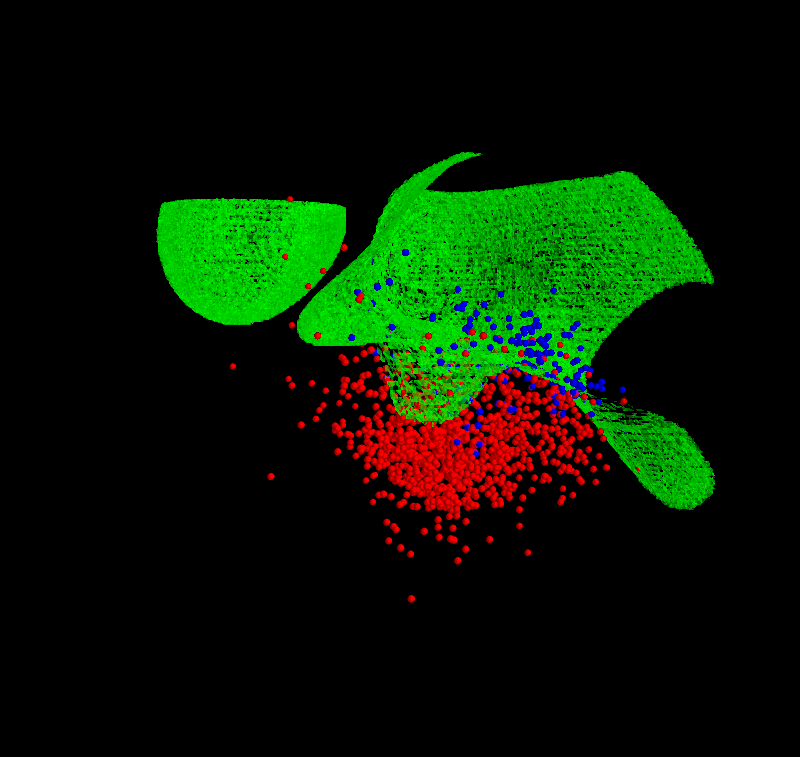